In [1]:
%cd /home/smalani/Cybernetic/growthcurvefit/alldatacsv/
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from tqdm import tqdm
import os

/home/smalani/Cybernetic/growthcurvefit/alldatacsv


In [2]:
# def baranyifun_ode(t, var, par):
#     X, S = var
#     q0, mu_max, Y, Ks, m = par
#     # Ks = 0.2
#     m = mu_max

#     a_t = q0 / (q0 + np.exp(-m * t))
#     mu = mu_max * a_t * S / (Ks + S)

#     dSdt = -mu * X / Y
#     dXdt = mu * X

#     return [dXdt, dSdt]

# def baranyifun(t_arr, p):

#     # Parameters
#     x0, s0, q0, mu_max, Y, Ks, m = p
#     tspan = [t_arr[0], t_arr[-1]]
#     init = [x0, s0]
#     pars = (q0, mu_max, Y, Ks, m,)
#     sol = solve_ivp(baranyifun_ode, tspan, init, args=(pars,), t_eval=t_arr, method='BDF', atol=1e-6, rtol=1e-9)

#     return sol.y[0,:]

def baranyifun(t_arr, p):

    # Parameters
    x0, mu_max, xmax, lambd = p

    y0 = np.log(x0)
    ymax = np.log(xmax)

    A = t_arr + (1/mu_max) * np.log(np.exp(-mu_max * t_arr) + np.exp(-mu_max * lambd) - np.exp(-mu_max * t_arr -mu_max * lambd))

    y_t = y0 + mu_max * A - np.log(1 + (np.exp(mu_max * A) - 1) / (np.exp(ymax - y0)))
    x_t = np.exp(y_t)

    return x_t

def fsolvefun(pars, df, label):
    mu_max, xmax, lambd = pars
    x0 = 0.01
    pars = x0, mu_max, xmax, lambd

    t_arr = df['Time'].iloc[:df[label].size].to_numpy()
    x_t = baranyifun(t_arr, pars)
    error = np.mean((x_t - df[label]) ** 2)

    return error# + (xmax - 10) * 10

Empty DataFrame
Columns: [Filename, Column, mu_max, xmax, lambd]
Index: []
[ 0.33680311 12.52732021 52.83851545]
0.09171984868536517
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Empty DataFrame
Columns: [Filename, Column, mu_max, xmax, lambd]
Index: []
[ 0.28877906 10.3391726  53.93898077]
0.0868879909766853
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Empty DataFrame
Columns: [Filename, Column, mu_max, xmax, lambd]
Index: []
[1.27750305e-01 1.26138939e+01 1.00000000e-10]
0.11616104191190868
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Empty DataFrame
Columns: [Filename, Column, mu_max, xmax, lambd]
Index: []
[1.38722094e-01 1.11461037e+01 1.00000000e-10]
0.20509080869549234
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Empty DataFrame
Columns: [Filename, Column, mu_max, xmax, lambd]
Index: []
[ 0.31189541 10.87047957  7.3949173 ]
0.05143427002734712
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Empty DataFrame
Columns: [Filename, Column, mu_max, xmax, lambd]
Index: []
[ 0

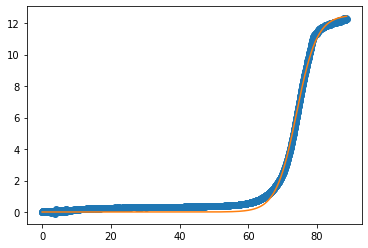

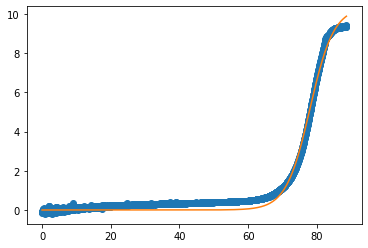

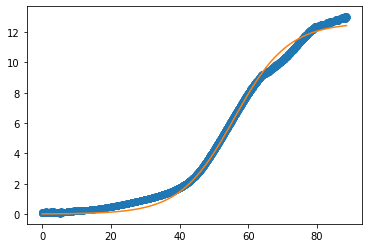

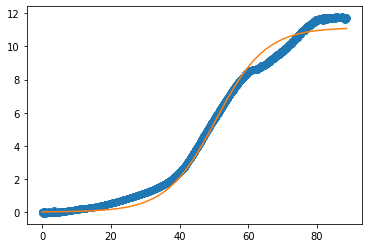

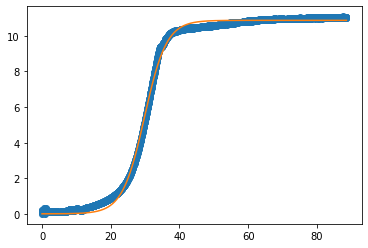

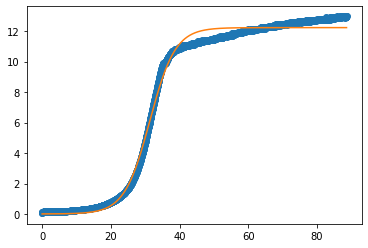

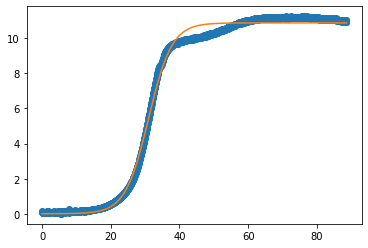

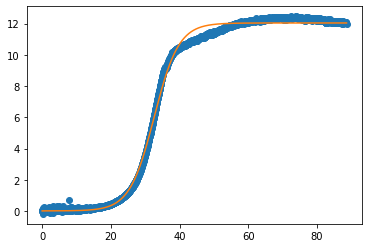

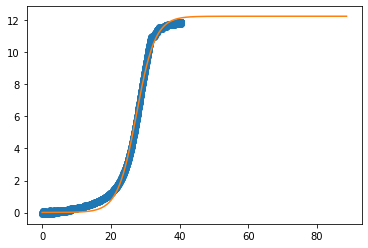

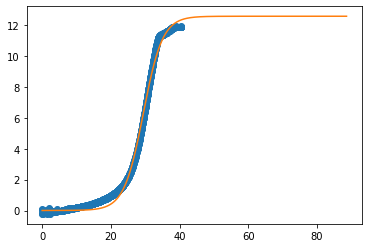

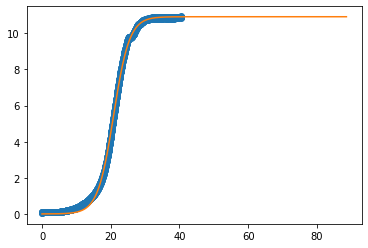

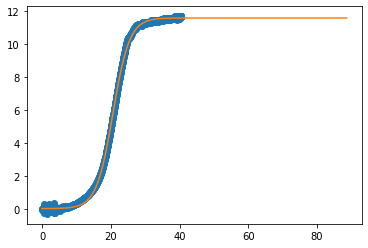

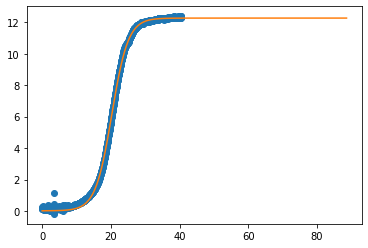

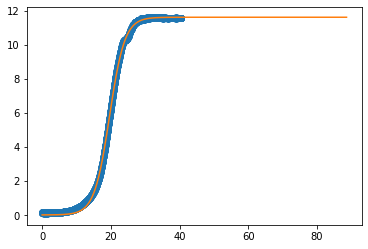

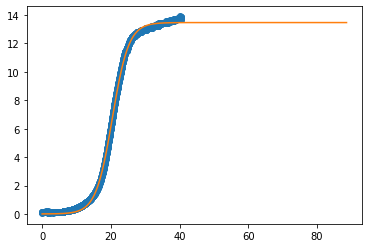

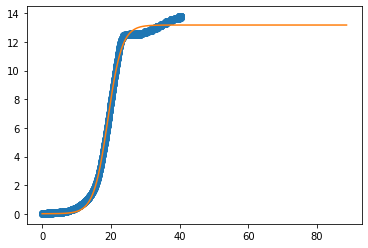

In [3]:
import glob
path = "/home/smalani/Cybernetic/growthcurvefit/alldatacsv/*.csv"

fsolve_guess = np.array([0.8, 10, 10])
bounds = tuple([(1e-10, None), (8, 16), (1e-10, None)])

mu_xls = pd.DataFrame(columns=['Filename',
        'Column',
        'mu_max',
        'xmax',
        'lambd'])

mu_list = []

for fname in glob.glob(path):
    filename = os.path.basename(fname)
    df = pd.read_csv(fname)
    column_names = df.columns[1:]
    for column in column_names:
        fsolve_sol = minimize(fsolvefun, fsolve_guess, args=(df[['Time',column]], column), method='L-BFGS-B', \
            bounds=bounds, options={'eps': 1e-9, 'maxls': 1000, 'gtol': 1e-15, 'ftol': 1e-15})

        mu_list.append({'Filename': filename, 'Column': column, 'mu_max': fsolve_sol.x[0], \
            'xmax': fsolve_sol.x[1], 'lambd': fsolve_sol.x[2]})

        if "103-12" in filename:
            print(mu_xls)

            print(fsolve_sol.x)
            print(fsolve_sol.fun)
            print(fsolve_sol.message)

            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(df['Time'], df[column], 'o', label='Data')

            mu_max, xmax, lambd= fsolve_sol.x
            x0 = 0.01
            pars = x0, mu_max, xmax, lambd
            
            ax.plot(df['Time'], baranyifun(df['Time'].to_numpy(), pars), label='Fit')

savefilename =  "/home/smalani/Cybernetic/growthcurvefit/alldatacsv/results.xlsx"
df = pd.DataFrame.from_records(mu_list)
df.to_excel(savefilename, sheet_name='sheet1', index=False)